### Using WEO to search for a methodology to group countries

When analyzing the economic performance of a country it is common to benchmark that performance against a set of "comparable" countires: region average, OECD average, developed countries, etc.

The idea here is to evaluate a set of economic indicators agnostically and see who goes with who according to the data.

We will use principal component analysis to understand how variability is decomposed within our data and Kmeans to try and group together countries using well-known indicators of macroeconomic performance

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

from sklearn.decomposition import PCA

As of the time of this notebook the IMF had recently published i'ts WEO update for October 2023

https://www.imf.org/en/Publications/WEO/weo-database/2023/October

In [2]:
path="~/WEO"
os.chdir(path)
cwd=os.getcwd()
os.listdir(cwd)

['.ipynb_checkpoints', 'country_grouping_v2.ipynb', 'WEO23.txt']

In [3]:
df=pd.read_csv('WEO23.txt',sep='\t')
print(df.shape)
df.head()

(8626, 59)


,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2020,2021,2022,2023,2024,2025,2026,2027,2028,Estimates Start After
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,288.87","1,021.60",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,NaN,"See notes for: Gross domestic product, consta...",NaN,...,-2.351,-20.737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,547.29","1,232.86",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,20.136,14.941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,81.007,67.093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0


In [4]:
df=df[df.Country.notnull()]
print(f"{len(df.Country.unique()) } countries excluding nans")
print(f"{len(df['Subject Descriptor'].unique())} variables to analyze")

196 countries excluding nans
28 variables to analyze


ok so let's start checking out variables and see what we find. Based on the columns it seems one variable can be shown in many units or scales

In [5]:
for variable in df['Subject Descriptor'].unique():
    print(f"{variable} :")
    print(df.loc[df['Subject Descriptor']==variable,:].Units.unique())
    print(df.loc[df['Subject Descriptor']==variable,:].Scale.unique())
    print("***")

Gross domestic product, constant prices :
['National currency' 'Percent change']
['Billions' nan]
***
Gross domestic product, current prices :
['National currency' 'U.S. dollars'
 'Purchasing power parity; international dollars']
['Billions']
***
Gross domestic product, deflator :
['Index']
[nan]
***
Gross domestic product per capita, constant prices :
['National currency' 'Purchasing power parity; 2017 international dollar']
['Units']
***
Gross domestic product per capita, current prices :
['National currency' 'U.S. dollars'
 'Purchasing power parity; international dollars']
['Units']
***
Output gap in percent of potential GDP :
['Percent of potential GDP']
[nan]
***
Gross domestic product based on purchasing-power-parity (PPP) share of world total :
['Percent']
[nan]
***
Implied PPP conversion rate :
['National currency per current international dollar']
[nan]
***
Total investment :
['Percent of GDP']
[nan]
***
Gross national savings :
['Percent of GDP']
[nan]
***
Inflation, average 

**Good candidates (measures that are broad enough and are expressed in a comparable unit)**:

Size-wise
- Workforce size (million people) or population or the ratio of one to another
- Gross domestic product, current prices (US dollars and some degree of percent variation over x period)
- Gross domestic product per capita, current prices (US dollars and some degree of percent variation over x period)

International involvement
- Volume of exports of goods and services (percent change average over some period of time)
- Current account balance, US dollars and percent of GDP average

Govt performance
- Inflation, average consumer prices (average over some period of time, variation over x period)
- General government revenue, percent of gdp
- General government net lending/borrowing, percent of gdp average
- General government gross debt, percent of gdp average


let's explore this variables, country distribution within each and how much data we have throughout the years

I'll start off by doing a high-level usability of each variable-scale-unit

basically a nonull share calc per decade

In [6]:
# Setting up some aids to better work with the dataset

references=['Country','Subject Descriptor','Units','Scale']

decade80s=[str(yr) for yr in range(1980,1990)]
decade90s=[str(yr) for yr in range(1990,2000)]
decade00s=[str(yr) for yr in range(2000,2010)]
decade10s=[str(yr) for yr in range(2010,2020)]

df['notnulls_80s']=df[decade80s].notnull().sum(axis=1)
df['notnulls_90s']=df[decade90s].notnull().sum(axis=1)
df['notnulls_00s']=df[decade00s].notnull().sum(axis=1)
df['notnulls_10s']=df[decade10s].notnull().sum(axis=1)
df['checker']=10 # we are grouping years in ten so max nonulls is 10

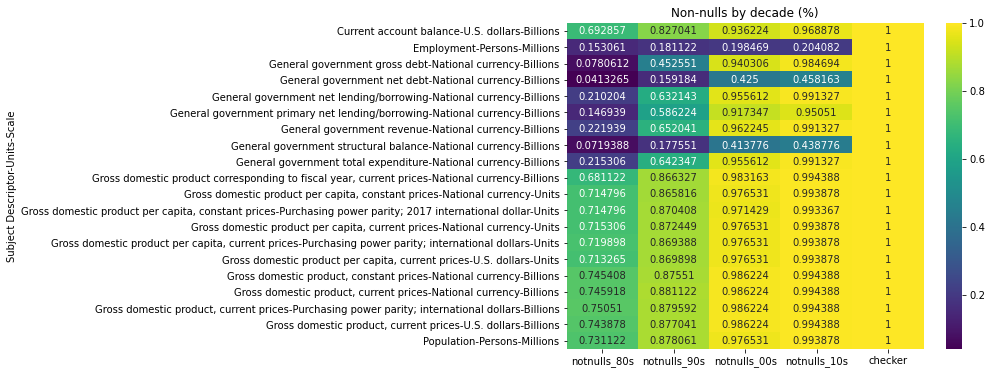

In [7]:
#quick overview of missing data by time and variable
df_overview=df.loc[:,references + ['notnulls_80s','notnulls_90s','notnulls_00s','notnulls_10s','checker']]
notnull_percentages=df_overview.groupby(['Subject Descriptor','Units','Scale']).sum()/1960 #196 countries times 10 years

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(notnull_percentages, annot=True, cmap='viridis', fmt='g')
plt.title('Non-nulls by decade (%)')
plt.show()

As of the year 2000 it seems like missing data is not going to be an issue outside a small set of variables

For now i'm just going to work for the the last 5 years of data unless we're analyzing dynamics for which we can expand that span ad-hoc. So i'll create a smaller version of the df with 2015-2019 (skipping COVID just to be safe)

In [8]:
df_5y=df.loc[:,references+['2015','2016','2017','2018','2019']].copy()
df_5y.head()

,Country,Subject Descriptor,Units,Scale,2015,2016,2017,2018,2019
0,Afghanistan,"Gross domestic product, constant prices",National currency,Billions,"1,197.01","1,222.92","1,255.29","1,270.22","1,319.90"
1,Afghanistan,"Gross domestic product, constant prices",Percent change,NaN,0.988,2.164,2.647,1.189,3.912
2,Afghanistan,"Gross domestic product, current prices",National currency,Billions,"1,226.57","1,222.92","1,285.46","1,327.69","1,469.60"
3,Afghanistan,"Gross domestic product, current prices",U.S. dollars,Billions,20.057,18.02,18.883,18.401,18.876
4,Afghanistan,"Gross domestic product, current prices",Purchasing power parity; international dollars,Billions,72.056,70.098,74.712,77.418,81.889


### Population

I'll rarely work on the whole of the table so i'm better of writing a function that let's me subset the DF for a specific variable more easily

In [9]:
def slicer(variable, unit='U.S. dollars', scale='Billions',df=df_5y):
    # give the slicer a variable, unit and scale and it will return the dataframe for that slice (5yrs of data)
    sliced_df = df[(df['Subject Descriptor']==variable) &
              (df['Units']==unit) &
              (df['Scale']==scale)].loc[:,['Country']+['2015','2016','2017','2018','2019']]
    sliced_df.set_index('Country', inplace=True)
    return(sliced_df)

In [10]:
def full_slicer(variable, unit='U.S. dollars', scale='Billions',df=df):
    # give the slicer a variable, unit and scale and it will return the dataframe for that slice (all years of data)
    sliced_df = df[(df['Subject Descriptor']==variable) &
              (df['Units']==unit) &
              (df['Scale']==scale)].loc[:,['Country']+decade80s+decade90s+decade00s+decade10s]
    sliced_df.set_index('Country', inplace=True)
    return(sliced_df)

i'm also creating a set of functions to help me do some simple univariate distribution checks so that i don't have to code this each time i'm examining a variable.

In [11]:
def df_prep(sliced_df):
    '''Take the sliced DF, drop countries with a third of data as nulls in that variable.
    Then drop thousands separators bc pandas cant read these properly as numbers'''
    #
    print(f"sliced df has a shape of {sliced_df.shape}")
    filtered_df=sliced_df[sliced_df.isnull().sum(axis=1)/sliced_df.isnull().count(axis=1) < .33].copy()
    print(print(f"filtered df has a shape of {filtered_df.shape}"))
    #
    for column in filtered_df.columns:
        filtered_df[column] = pd.to_numeric(filtered_df[column].str.replace(',',''), errors='coerce')
    return filtered_df

First step is to reduce data to a metric, so that we can then assess distance btw countries in terms of these variables. I'll take 5yr means out of the variable. for a cleaner visualization of a data inside the histograms ill also use a short function that prints the count of countries that fall btw each bin (chose 25 bc data is quite scattered but i still dont want huge lists that i cannot process visually)

In [12]:
def varmeans(sliced_df):
    slice_means=sliced_df.mean(axis=1, skipna=True)
    return slice_means

def show_bins(slice_means):
    bins=math.floor((slice_means.max()-slice_means.min())/25)
    for i in range(math.floor(slice_means.min()),math.floor(slice_means.max()),bins):
        print(f"{i}-{i+bins}: {len(slice_means[(slice_means>i) & (slice_means<i+bins)])}")

So this is basically what im going to do as EDA for the univariate distributions:
- Clean
- Take five year means
- Show histograms and bins
- Additionally let's see the top and bottom 5 for each variable, may help to make it more educational

In [13]:
def print_top(slice_means):
    print(f"mean: {slice_means.mean()}")
    print(f" Bottom 5: \n{slice_means.sort_values().head(5)}\n")
    print(f" Top 5: \n{slice_means.sort_values().tail(5)}\n")

Let's start with "static" measures as these should be easier to work with

### Population

In [14]:
pop_data=slicer('Population','Persons','Millions')
pop_data=df_prep(pop_data)
pop_data.head()

sliced df has a shape of (196, 5)
filtered df has a shape of (195, 5)
None


,2015,2016,2017,2018,2019
Country,,,,,
Afghanistan,28.425,29.200,29.700,31.600,32.200
Albania,2.881,2.876,2.884,2.883,2.881
Algeria,39.963,40.836,41.721,42.578,43.424
Andorra,0.072,0.073,0.075,0.076,0.078
Angola,28.128,29.155,30.209,31.274,32.354


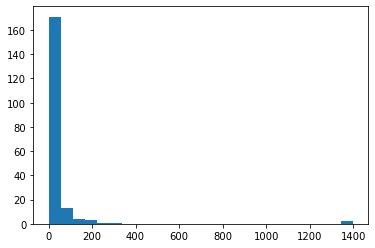

0-55: 171
55-110: 13
110-165: 4
165-220: 3
220-275: 1
275-330: 1
330-385: 0
385-440: 0
440-495: 0
495-550: 0
550-605: 0
605-660: 0
660-715: 0
715-770: 0
770-825: 0
825-880: 0
880-935: 0
935-990: 0
990-1045: 0
1045-1100: 0
1100-1155: 0
1155-1210: 0
1210-1265: 0
1265-1320: 0
1320-1375: 1
1375-1430: 1
***************
 Bottom 5: 
Country
Tuvalu              0.0110
Nauru               0.0122
Palau               0.0180
San Marino          0.0332
Marshall Islands    0.0470
dtype: float64

 Top 5: 
Country
Pakistan          205.0860
Indonesia         261.3030
United States     324.9994
India            1353.5640
China            1398.2360
dtype: float64



In [15]:
pop_means=varmeans(pop_data)
plt.hist(pop_means, bins=25)
plt.show()
show_bins(pop_means)
print("*"*15)
print(f" Bottom 5: \n{pop_means.sort_values().head(5)}\n")
print(f" Top 5: \n{pop_means.sort_values().tail(5)}\n")

Clearly China and India are their own category. Then it depends on how granular you want to go, as you have 20 countries in 50M-300M people and still that band is pretty wide. There's space to split the <50M group as well. Big chunk of this group is below the 10M mark

(array([55., 22., 18., 11., 15.,  3.,  4.,  6.,  5.,  2.,  4.,  1.,  7.,
         3.,  1.,  4.,  0.,  3.,  1.,  3.]),
 array([1.100000e-02, 2.392620e+00, 4.774240e+00, 7.155860e+00,
        9.537480e+00, 1.191910e+01, 1.430072e+01, 1.668234e+01,
        1.906396e+01, 2.144558e+01, 2.382720e+01, 2.620882e+01,
        2.859044e+01, 3.097206e+01, 3.335368e+01, 3.573530e+01,
        3.811692e+01, 4.049854e+01, 4.288016e+01, 4.526178e+01,
        4.764340e+01]),
 <BarContainer object of 20 artists>)

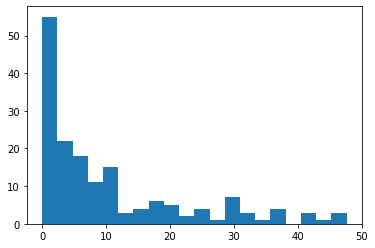

In [16]:
plt.hist(pop_means[pop_means<50], bins=20)

I could also be looking at population increases over time but given that my POV is mainly economic I will rely on the assumption that GDP will reflect any relevant population changes

### GDP

sliced df has a shape of (196, 5)
filtered df has a shape of (195, 5)
None


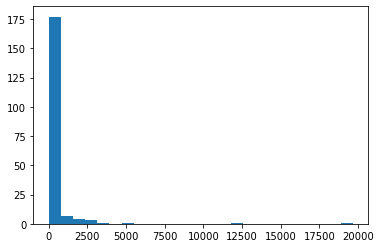

0-786: 177
786-1572: 7
1572-2358: 4
2358-3144: 3
3144-3930: 1
3930-4716: 0
4716-5502: 1
5502-6288: 0
6288-7074: 0
7074-7860: 0
7860-8646: 0
8646-9432: 0
9432-10218: 0
10218-11004: 0
11004-11790: 0
11790-12576: 1
12576-13362: 0
13362-14148: 0
14148-14934: 0
14934-15720: 0
15720-16506: 0
16506-17292: 0
17292-18078: 0
18078-18864: 0
18864-19650: 0
19650-20436: 1
***************
mean: 416.1918307692307
 Bottom 5: 
Country
Tuvalu              0.0450
Nauru               0.1094
Kiribati            0.1818
Marshall Islands    0.2096
Palau               0.2894
dtype: float64

 Top 5: 
Country
United Kingdom     2814.282
Germany            3676.448
Japan              4907.666
China             12557.630
United States     19658.502
dtype: float64



In [17]:
gdp_data=slicer('Gross domestic product, current prices')# dont need nothing else bc dollars and billions are the function defo
gdp_data=df_prep(gdp_data)
#
gdp_means=varmeans(gdp_data)
plt.hist(gdp_means, bins=25)
plt.show()
show_bins(gdp_means)
print("*"*15)
print_top(gdp_means)

Also very skewed, kind of makes sense since very intertwined with population. Let's try GDP per capita

sliced df has a shape of (196, 5)
filtered df has a shape of (195, 5)
None


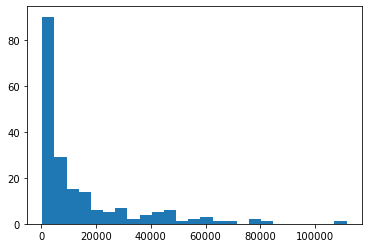

281-4731: 90
4731-9181: 29
9181-13631: 15
13631-18081: 14
18081-22531: 6
22531-26981: 5
26981-31431: 7
31431-35881: 2
35881-40331: 4
40331-44781: 5
44781-49231: 5
49231-53681: 2
53681-58131: 2
58131-62581: 3
62581-67031: 1
67031-71481: 1
71481-75931: 0
75931-80381: 2
80381-84831: 1
84831-89281: 0
89281-93731: 0
93731-98181: 0
98181-102631: 0
102631-107081: 0
107081-111531: 0
111531-115981: 1
***************
mean: 14238.40520205129
 Bottom 5: 
Country
Burundi                     281.9494
Central African Republic    439.7942
South Sudan                 442.5638
Malawi                      484.8220
Mozambique                  498.5804
dtype: float64

 Top 5: 
Country
Ireland         70849.454
Norway          76009.438
Macao SAR       76167.208
Switzerland     83882.648
Luxembourg     111544.868
dtype: float64



In [18]:
gdppc_data=slicer('Gross domestic product per capita, current prices',scale='Units')
gdppc_data=df_prep(gdppc_data)
#
gdppc_means=varmeans(gdppc_data)
plt.hist(gdppc_means, bins=25)
plt.show()
show_bins(gdppc_means)
print("*"*15)
print_top(gdppc_means)

It does look a bit better, altough it seems that gdp per capita is naturally bigger for smaller countries so it does have a potential bias. let's scatter these two dimensions to ilustrate the point

In [19]:
pop_mean_df=pop_means.to_frame(name='popmean')
scaler=StandardScaler()
pop_mean_scaled=scaler.fit_transform(pop_mean_df)

gdppc_means_df=gdppc_means.to_frame(name='gdppc')
scaler=StandardScaler()
gdppc_means_scaled=scaler.fit_transform(gdppc_means_df)

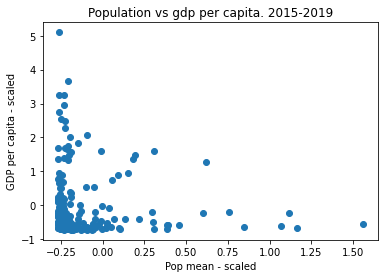

In [20]:
# remember pop is highly skewed so we should take out big countries to be able to zoom in a bit into the relationship
plt.scatter(pop_mean_scaled[pop_mean_scaled<2],gdppc_means_scaled[pop_mean_scaled<2])
plt.title("Population vs gdp per capita. 2015-2019")
plt.xlabel("Pop mean - scaled")
plt.ylabel("GDP per capita - scaled")
plt.show()

Now let's see time trends per country; i'm thinking decade-long growth in gdp per capita, of course this decision can be later tested against other settings

In [21]:
gdppc_full=full_slicer('Gross domestic product per capita, current prices',scale='Units')
gdppc_full=df_prep(gdppc_full)
gdppc_growth=(gdppc_full[decade10s].iloc[:,-1]/gdppc_full[decade10s].iloc[:,0])-1

sliced df has a shape of (196, 40)
filtered df has a shape of (169, 40)
None


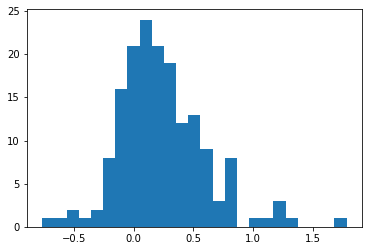

***************
mean: 0.23853524602565007
 Bottom 5: 
Country
Venezuela                  -0.764799
Islamic Republic of Iran   -0.583475
Sudan                      -0.525433
Equatorial Guinea          -0.512898
Yemen                      -0.445954
dtype: float64

 Top 5: 
Country
Cambodia      1.202943
China         1.260114
Bangladesh    1.302130
Ethiopia      1.781714
Syria              NaN
dtype: float64



In [22]:
plt.hist(gdppc_growth, bins=25)
plt.show()
print("*"*15)
print_top(gdppc_growth)

Nice normal distribution, some outliers yes, but it also seems to be quite conditional on country size (which makes sense according to the theory of convergence

Let's also see how erratic the growth path is via the Coefficient of Variance in gdp per capita growth

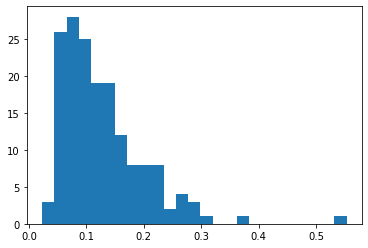

***************
mean: 0.12807553184761092
 Bottom 5: 
Country
Lebanon        0.022911
Belize         0.037970
Barbados       0.043474
Switzerland    0.046898
Jamaica        0.051179
dtype: float64

 Top 5: 
Country
Bangladesh           0.293108
Ethiopia             0.314906
Equatorial Guinea    0.377580
Venezuela            0.553279
Syria                     NaN
dtype: float64



In [23]:
gdppc_CV=gdppc_full.loc[:,decade10s].std(axis=1)/gdppc_full.loc[:,decade10s].mean(axis=1)
plt.hist(gdppc_CV, bins=25)
plt.show()
print("*"*15)
print_top(gdppc_CV)

### Current account balance

sliced df has a shape of (196, 5)
filtered df has a shape of (192, 5)
None


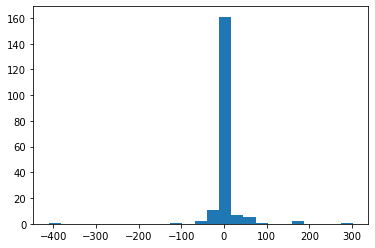

-411--383: 1
-383--355: 0
-355--327: 0
-327--299: 0
-299--271: 0
-271--243: 0
-243--215: 0
-215--187: 0
-187--159: 0
-159--131: 0
-131--103: 1
-103--75: 0
-75--47: 1
-47--19: 7
-19-9: 160
9-37: 12
37-65: 5
65-93: 2
93-121: 0
121-149: 0
149-177: 1
177-205: 1
205-233: 0
233-261: 0
261-289: 0
289-317: 1
***************
mean: 1.6266606770833316
 Bottom 5: 
Country
United States    -410.7768
United Kingdom   -118.5156
Brazil            -48.4182
Canada            -44.5760
India             -33.3662
dtype: float64

 Top 5: 
Country
Taiwan Province of China     72.7388
Korea                        83.0834
China                       160.0152
Japan                       178.3848
Germany                     302.0584
dtype: float64



In [24]:
account_data=slicer('Current account balance')
account_data=df_prep(account_data)
#
account_means=varmeans(account_data)
plt.hist(account_means, bins=25)
plt.show()
show_bins(account_means)
print("*"*15)
print_top(account_means)

This is the first variable that can take on negative values, overall seems normally distributed around zero, altough we have some prominent outliers, namely the USA

### Govt performance

#### Govt size

In [25]:
# can't use my slice function bc scale here is null
# since this will happen for all percent of gdp measures I might as well do an alternate function

def slicer_percent(variable, unit='Percent of GDP',df=df_5y):
    sliced_df = df[(df['Subject Descriptor']==variable) &
              (df['Units']==unit) &
              (df_5y['Scale'].isnull())].loc[:,['Country']+['2015','2016','2017','2018','2019']]
    sliced_df.set_index('Country', inplace=True)
    return(sliced_df)

In [26]:
gvt_size_data=slicer_percent('General government total expenditure')
gvt_size_data.head()

,2015,2016,2017,2018,2019
Country,,,,,
Afghanistan,25.947,28.029,27.732,28.936,27.999
Albania,30.758,29.139,29.162,29.077,29.075
Algeria,46.222,41.995,41.119,40.321,41.786
Andorra,33.329,34.568,34.852,35.93,35.844
Angola,27.051,22.043,24.103,20.579,20.403


sliced df has a shape of (196, 5)
filtered df has a shape of (195, 5)
None


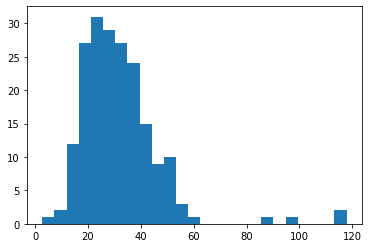

2-6: 1
6-10: 0
10-14: 6
14-18: 16
18-22: 30
22-26: 22
26-30: 24
30-34: 24
34-38: 21
38-42: 20
42-46: 9
46-50: 10
50-54: 4
54-58: 3
58-62: 1
62-66: 0
66-70: 0
70-74: 0
74-78: 0
78-82: 0
82-86: 0
86-90: 1
90-94: 0
94-98: 1
98-102: 0
102-106: 0
106-110: 0
110-114: 0
114-118: 2
***************
mean: 31.81198564102564
 Bottom 5: 
Country
Somalia          2.6256
Haiti           10.8746
Nigeria         11.6290
Bangladesh      12.3682
Turkmenistan    12.7866
dtype: float64

 Top 5: 
Country
Marshall Islands     60.7564
Timor-Leste          89.9768
Nauru                97.3594
Tuvalu              116.3980
Kiribati            117.8544
dtype: float64



In [27]:
gvt_size_data=df_prep(gvt_size_data)
#
gvt_size_means=varmeans(gvt_size_data)
plt.hist(gvt_size_means, bins=25)
plt.show()
show_bins(gvt_size_means)
print("*"*15)
print_top(gvt_size_means)

again, somewhat of a normal distribution with outliers

#### Govt fiscal result

sliced df has a shape of (196, 5)
filtered df has a shape of (187, 5)
None


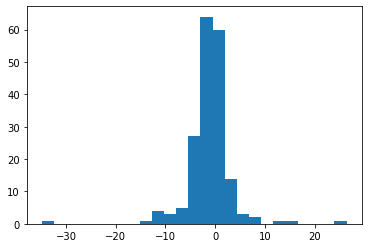

-35--33: 1
-33--31: 0
-31--29: 0
-29--27: 0
-27--25: 0
-25--23: 0
-23--21: 0
-21--19: 0
-19--17: 0
-17--15: 0
-15--13: 1
-13--11: 2
-11--9: 4
-9--7: 2
-7--5: 6
-5--3: 24
-3--1: 49
-1-1: 56
1-3: 30
3-5: 4
5-7: 3
7-9: 2
9-11: 0
11-13: 0
13-15: 1
15-17: 1
17-19: 0
19-21: 0
21-23: 0
23-25: 0
25-27: 1
***************
mean: -1.0112058823529413
 Bottom 5: 
Country
Timor-Leste         -34.7906
Venezuela           -13.5694
Saudi Arabia        -11.1030
Oman                -11.0050
Brunei Darussalam   -10.7752
dtype: float64

 Top 5: 
Country
Jamaica        7.3602
Tuvalu         8.6864
Macao SAR     13.2404
Micronesia    15.2368
Kiribati      26.4014
dtype: float64



In [28]:
fiscal_data=slicer_percent('General government primary net lending/borrowing')
fiscal_data=df_prep(fiscal_data)
fiscal_means=varmeans(fiscal_data)
plt.hist(fiscal_means, bins=25)
plt.show()
show_bins(fiscal_means)
print("*"*15)
print_top(fiscal_means)

Most governments are deficient (pretends to be shocked). Some outliers but not horrible. Again, normally distributed

I should probably look at how this looks for different time spans, as 5 years is more of a span to measure cycle than trend

In [29]:
df_10y=df.loc[:,references+decade10s].copy()
df_20y=df.loc[:,references+decade00s+decade10s].copy()

sliced df has a shape of (196, 5)
filtered df has a shape of (187, 5)
None


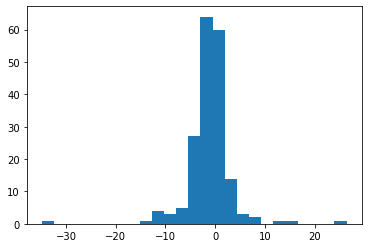

-35--33: 1
-33--31: 0
-31--29: 0
-29--27: 0
-27--25: 0
-25--23: 0
-23--21: 0
-21--19: 0
-19--17: 0
-17--15: 0
-15--13: 1
-13--11: 2
-11--9: 4
-9--7: 2
-7--5: 6
-5--3: 24
-3--1: 49
-1-1: 56
1-3: 30
3-5: 4
5-7: 3
7-9: 2
9-11: 0
11-13: 0
13-15: 1
15-17: 1
17-19: 0
19-21: 0
21-23: 0
23-25: 0
25-27: 1
***************
mean: -1.0112058823529413
 Bottom 5: 
Country
Timor-Leste         -34.7906
Venezuela           -13.5694
Saudi Arabia        -11.1030
Oman                -11.0050
Brunei Darussalam   -10.7752
dtype: float64

 Top 5: 
Country
Jamaica        7.3602
Tuvalu         8.6864
Macao SAR     13.2404
Micronesia    15.2368
Kiribati      26.4014
dtype: float64



In [30]:
fiscal_data=slicer_percent(variable='General government primary net lending/borrowing',df=df_10y)
fiscal_data=df_prep(fiscal_data)
fiscal_means=varmeans(fiscal_data)
plt.hist(fiscal_means, bins=25)
plt.show()
show_bins(fiscal_means)
print("*"*15)
print_top(fiscal_means)

sliced df has a shape of (196, 5)
filtered df has a shape of (187, 5)
None


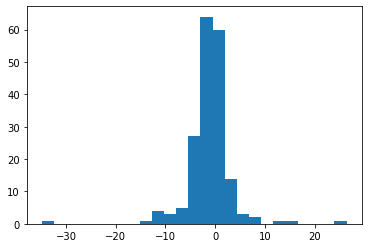

-35--33: 1
-33--31: 0
-31--29: 0
-29--27: 0
-27--25: 0
-25--23: 0
-23--21: 0
-21--19: 0
-19--17: 0
-17--15: 0
-15--13: 1
-13--11: 2
-11--9: 4
-9--7: 2
-7--5: 6
-5--3: 24
-3--1: 49
-1-1: 56
1-3: 30
3-5: 4
5-7: 3
7-9: 2
9-11: 0
11-13: 0
13-15: 1
15-17: 1
17-19: 0
19-21: 0
21-23: 0
23-25: 0
25-27: 1
***************
mean: -1.0112058823529413
 Bottom 5: 
Country
Timor-Leste         -34.7906
Venezuela           -13.5694
Saudi Arabia        -11.1030
Oman                -11.0050
Brunei Darussalam   -10.7752
dtype: float64

 Top 5: 
Country
Jamaica        7.3602
Tuvalu         8.6864
Macao SAR     13.2404
Micronesia    15.2368
Kiribati      26.4014
dtype: float64



In [31]:
fiscal_data=slicer_percent(variable='General government primary net lending/borrowing',df=df_20y)
fiscal_data=df_prep(fiscal_data)
fiscal_means=varmeans(fiscal_data)
plt.hist(fiscal_means, bins=25)
plt.show()
show_bins(fiscal_means)
print("*"*15)
print_top(fiscal_means)

Not very different, really. I'll keep my five year data for consistency

In [32]:
fiscal_data=slicer_percent('General government primary net lending/borrowing')
fiscal_data=df_prep(fiscal_data)
fiscal_means=varmeans(fiscal_data)

sliced df has a shape of (196, 5)
filtered df has a shape of (187, 5)
None


### Working with combined variables

In [33]:
selected_variables={
    "Current GDP": gdp_means,
    "GDP per capita": gdppc_means,
    "GDPpc growth": gdppc_growth,
    "GDPpc growth dispersion": gdppc_CV,
    "Current account balance %": account_means,
    "Government size %": gvt_size_means,
    "Government prim result": fiscal_means
}

weo_kpi = pd.concat(selected_variables.values(), axis=1, join='outer', keys=selected_variables.keys())

In [34]:
# amount of missing data
for c in weo_kpi.columns:
    print(f"{c}:")
    print(weo_kpi[weo_kpi[c].isnull()].index.tolist())
    print("*"*20)

Current GDP:
['Syria']
********************
GDP per capita:
['Syria']
********************
GDPpc growth:
['Afghanistan', 'Andorra', 'Aruba', 'Bosnia and Herzegovina', 'Czech Republic', 'Georgia', 'Iraq', 'Kosovo', 'Liberia', 'Lithuania', 'Macao SAR', 'Malta', 'Marshall Islands', 'Micronesia', 'Montenegro', 'Myanmar', 'Nauru', 'Nicaragua', 'Palau', 'Samoa', 'San Marino', 'Serbia', 'Somalia', 'South Sudan', 'Timor-Leste', 'Tuvalu', 'West Bank and Gaza', 'Syria']
********************
GDPpc growth dispersion:
['Afghanistan', 'Andorra', 'Aruba', 'Bosnia and Herzegovina', 'Czech Republic', 'Georgia', 'Iraq', 'Kosovo', 'Liberia', 'Lithuania', 'Macao SAR', 'Malta', 'Marshall Islands', 'Micronesia', 'Montenegro', 'Myanmar', 'Nauru', 'Nicaragua', 'Palau', 'Samoa', 'San Marino', 'Serbia', 'Somalia', 'South Sudan', 'Timor-Leste', 'Tuvalu', 'West Bank and Gaza', 'Syria']
********************
Current account balance %:
['Andorra', 'Puerto Rico', 'San Marino', 'Syria']
********************
Government

In [35]:
# its not ok to have that many nulls so let's try to find our way around it
missing_1=weo_kpi[weo_kpi['GDPpc growth'].isnull()].index.tolist()
missing_2=weo_kpi[weo_kpi['GDPpc growth dispersion'].isnull()].index.tolist()
missing_3=weo_kpi[weo_kpi['Government prim result'].isnull()].index.tolist()
# For missing_3 I have no data at all here so not much to do

From what it shows it seems can salvage all of gdp nulls if I take the 2012-2019 period as the window instead

In [36]:
gdppc_data=full_slicer('Gross domestic product per capita, current prices',scale='Units')
gdppc_data.loc[missing_1]

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,631.49,714.7,784.611,754.402,746.922,705.597,617.126,635.789,582.323,586.204
Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"49,030.23","51,957.31","45,713.97","45,630.20","46,299.28","38,877.49","39,595.32","40,017.74","42,229.90","40,688.49"
Aruba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"24,093.09","25,712.45","25,119.74","25,813.52","26,129.73","27,458.23","27,441.58","28,440.09","30,082.21","31,096.32"
Bosnia and Herzegovina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"4,633.86","5,089.85","4,773.16","5,141.57","5,252.94","4,662.98","4,875.23","5,230.13","5,859.28","5,867.26"
Czech Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"19,983.58","21,890.78","19,880.90","20,129.62","19,915.38","17,842.87","18,553.30","20,605.83","23,380.77","23,616.01"
Georgia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"3,221.63","4,003.46","4,409.63","4,622.55","4,742.50","4,017.62","4,060.89","4,358.59","4,718.79","4,693.66"
Iraq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"4,473.71","5,848.54","6,692.58","7,021.41","6,704.31","5,044.62","4,639.50","5,178.92","5,959.10","5,945.44"
Kosovo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"3,013.16","3,562.03","3,396.89","3,699.48","3,920.47","3,554.10","3,745.86","3,991.25","4,389.63","4,433.00"
Liberia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,505.363,582.614,646.662,716.576,708.816,691.369,709.824,706.239,677.356,623.887


In [37]:
# re-set the time span for the slicing for the gdppc data
# then mimic my cleaning function without striping obs with many nulls
small_range=[str(yr) for yr in range(2012,2020)]
gdppc_data=gdppc_data.loc[:,small_range].copy()
#
for column in gdppc_data.columns:
    gdppc_data[column] = pd.to_numeric(gdppc_data[column].str.replace(',',''), errors='coerce')

In [38]:
#re-do variables with new subset
gdppc_growth=(gdppc_data.iloc[:,-1]/gdppc_data.iloc[:,0])-1
gdppc_CV=gdppc_data.std(axis=1)/gdppc_data.mean(axis=1)

#reload my selected variables dataframe to account for the changes
selected_variables={
    "Current GDP": gdp_means,
    "GDP per capita": gdppc_means,
    "GDPpc growth": gdppc_growth,
    "GDPpc growth dispersion": gdppc_CV,
    "Current account balance %": account_means,
    "Government size %": gvt_size_means,
    "Government prim result": fiscal_means
}

weo_kpi = pd.concat(selected_variables.values(), axis=1, join='outer', keys=selected_variables.keys())

In [39]:
# amount of missing data
for c in weo_kpi.columns:
    print(f"{c}:")
    print(weo_kpi[weo_kpi[c].isnull()].index.tolist())
    print("*"*20)

Current GDP:
['Syria']
********************
GDP per capita:
['Syria']
********************
GDPpc growth:
['Syria']
********************
GDPpc growth dispersion:
['Syria']
********************
Current account balance %:
['Andorra', 'Puerto Rico', 'San Marino', 'Syria']
********************
Government size %:
['Syria']
********************
Government prim result:
['Andorra', 'Nauru', 'Palau', 'Samoa', 'Singapore', 'Taiwan Province of China', 'Turkmenistan', 'West Bank and Gaza', 'Syria']
********************


In [40]:
# I have 195 countries to work with
weo_kpi=weo_kpi[weo_kpi.notna().all(axis=1)].copy()
#scale to standard so our later analysis is not affected by scales
scaled_kpi = pd.DataFrame(scaler.fit_transform(weo_kpi), columns=weo_kpi.columns)
scaled_kpi.shape

(185, 7)

********************
Scatter plots with Current GDP as the base variable
********************
scaterplot of Current GDP against Current GDP:


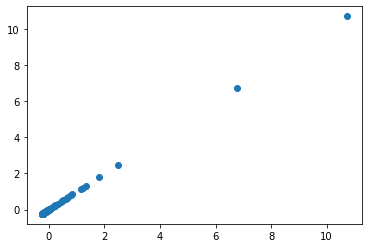

scaterplot of Current GDP against GDP per capita:


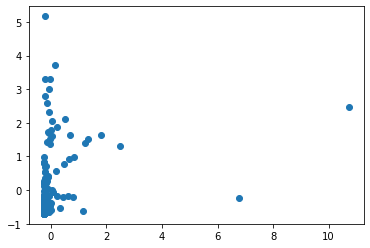

scaterplot of Current GDP against GDPpc growth:


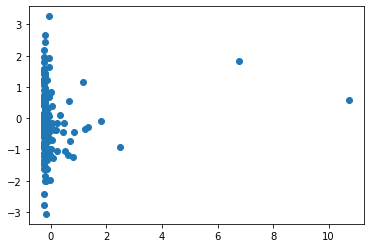

scaterplot of Current GDP against GDPpc growth dispersion:


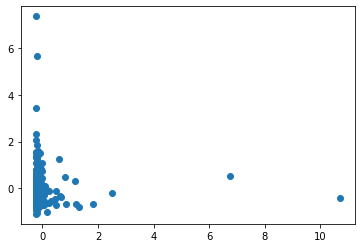

scaterplot of Current GDP against Current account balance %:


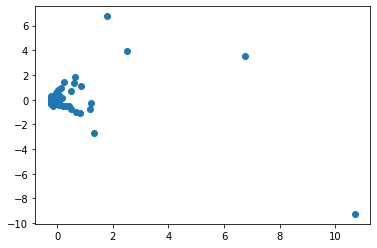

scaterplot of Current GDP against Government size %:


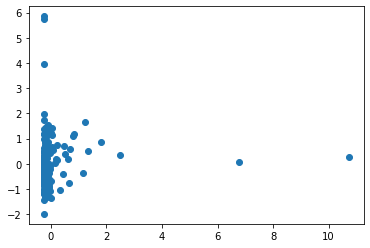

scaterplot of Current GDP against Government prim result:


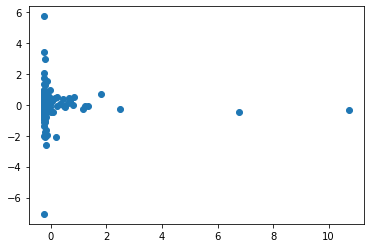

********************
Scatter plots with GDP per capita as the base variable
********************
scaterplot of GDP per capita against Current GDP:


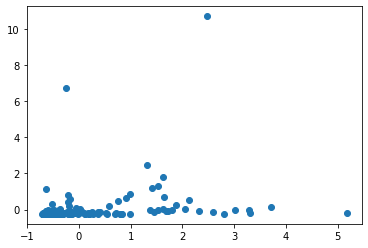

scaterplot of GDP per capita against GDP per capita:


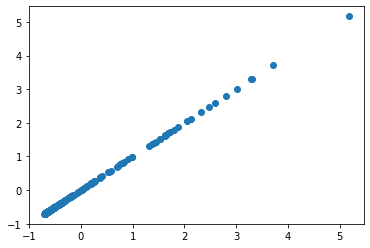

scaterplot of GDP per capita against GDPpc growth:


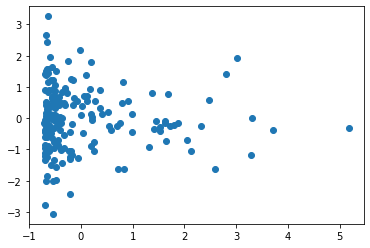

scaterplot of GDP per capita against GDPpc growth dispersion:


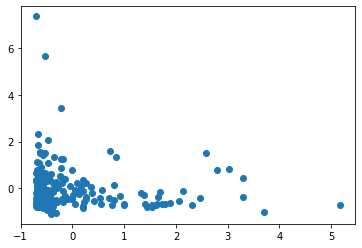

scaterplot of GDP per capita against Current account balance %:


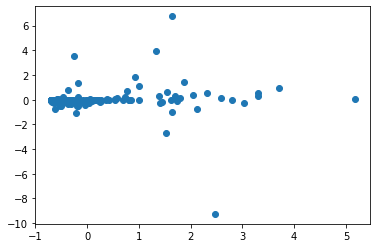

scaterplot of GDP per capita against Government size %:


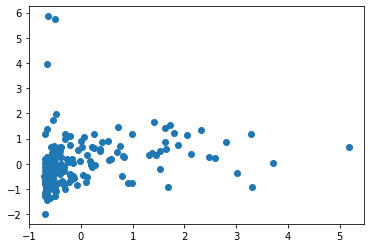

scaterplot of GDP per capita against Government prim result:


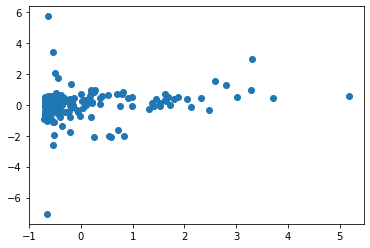

********************
Scatter plots with GDPpc growth as the base variable
********************
scaterplot of GDPpc growth against Current GDP:


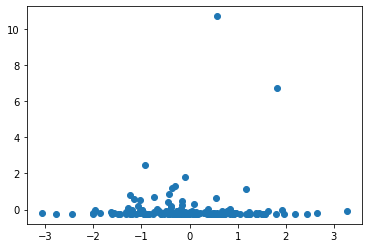

scaterplot of GDPpc growth against GDP per capita:


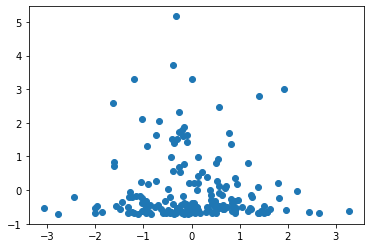

scaterplot of GDPpc growth against GDPpc growth:


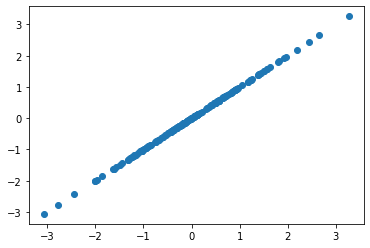

scaterplot of GDPpc growth against GDPpc growth dispersion:


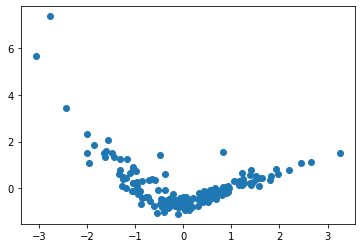

scaterplot of GDPpc growth against Current account balance %:


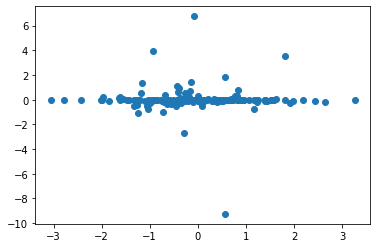

scaterplot of GDPpc growth against Government size %:


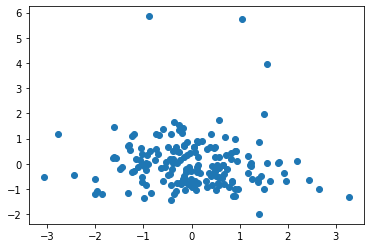

scaterplot of GDPpc growth against Government prim result:


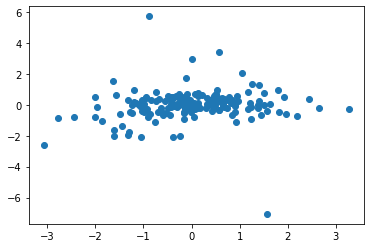

********************
Scatter plots with GDPpc growth dispersion as the base variable
********************
scaterplot of GDPpc growth dispersion against Current GDP:


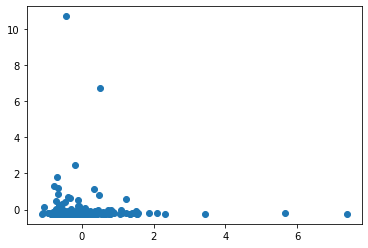

scaterplot of GDPpc growth dispersion against GDP per capita:


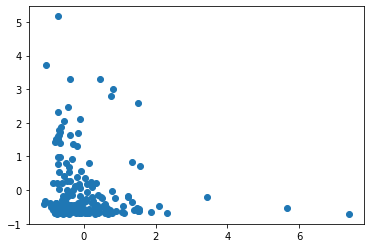

scaterplot of GDPpc growth dispersion against GDPpc growth:


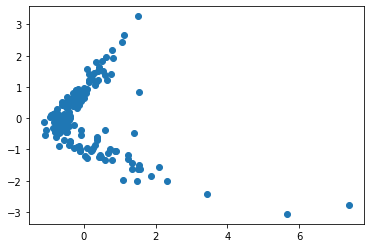

scaterplot of GDPpc growth dispersion against GDPpc growth dispersion:


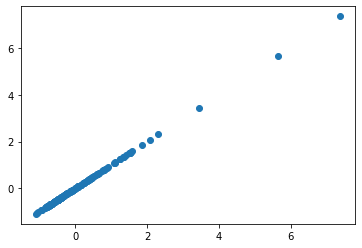

scaterplot of GDPpc growth dispersion against Current account balance %:


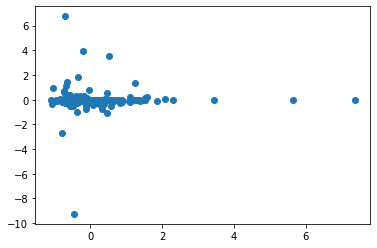

scaterplot of GDPpc growth dispersion against Government size %:


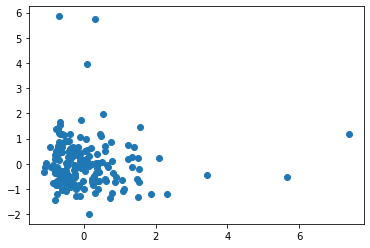

scaterplot of GDPpc growth dispersion against Government prim result:


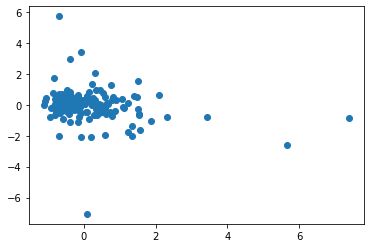

********************
Scatter plots with Current account balance % as the base variable
********************
scaterplot of Current account balance % against Current GDP:


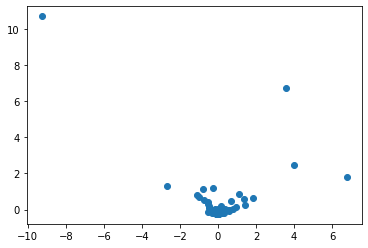

scaterplot of Current account balance % against GDP per capita:


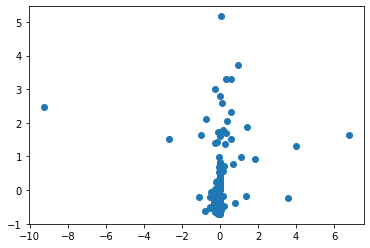

scaterplot of Current account balance % against GDPpc growth:


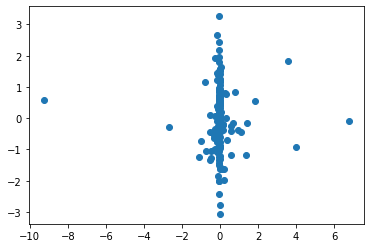

scaterplot of Current account balance % against GDPpc growth dispersion:


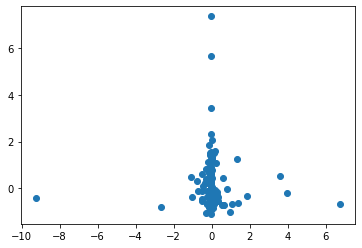

scaterplot of Current account balance % against Current account balance %:


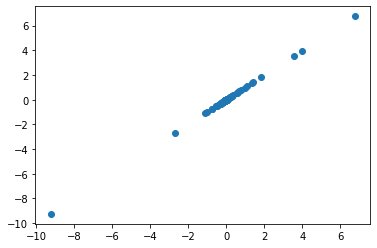

scaterplot of Current account balance % against Government size %:


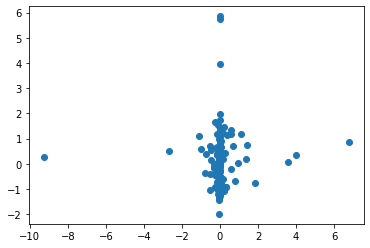

scaterplot of Current account balance % against Government prim result:


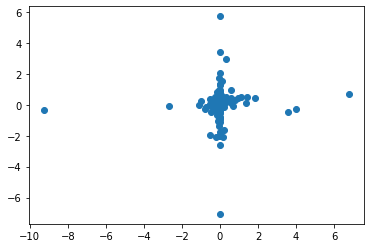

********************
Scatter plots with Government size % as the base variable
********************
scaterplot of Government size % against Current GDP:


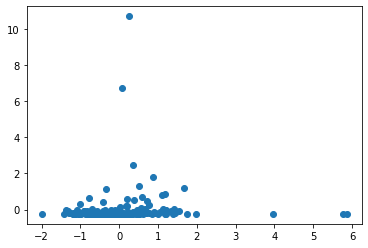

scaterplot of Government size % against GDP per capita:


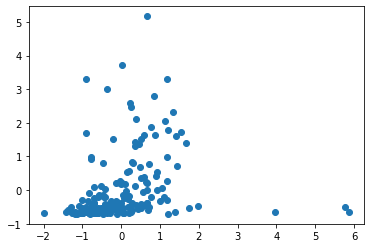

scaterplot of Government size % against GDPpc growth:


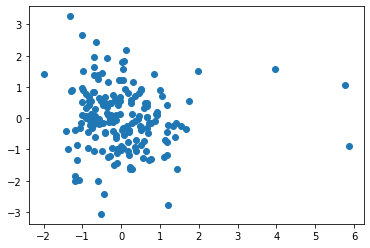

scaterplot of Government size % against GDPpc growth dispersion:


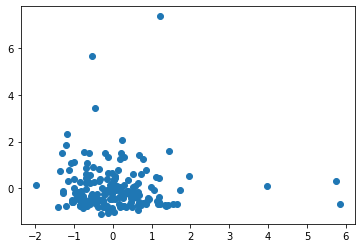

scaterplot of Government size % against Current account balance %:


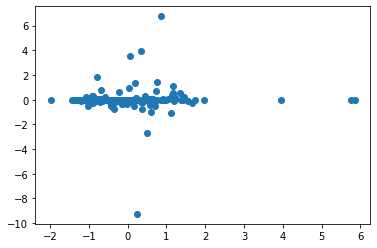

scaterplot of Government size % against Government size %:


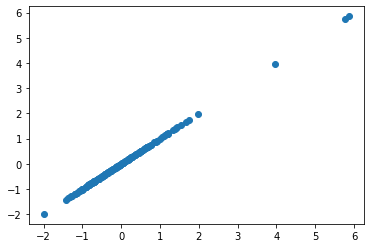

scaterplot of Government size % against Government prim result:


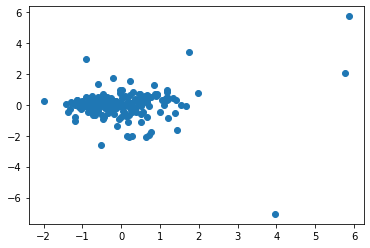

********************
Scatter plots with Government prim result as the base variable
********************
scaterplot of Government prim result against Current GDP:


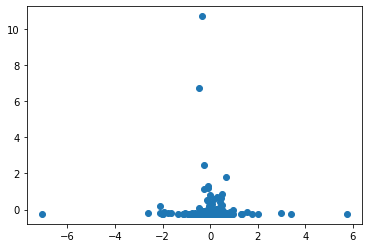

scaterplot of Government prim result against GDP per capita:


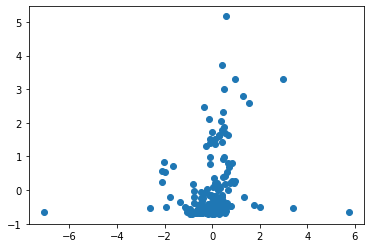

scaterplot of Government prim result against GDPpc growth:


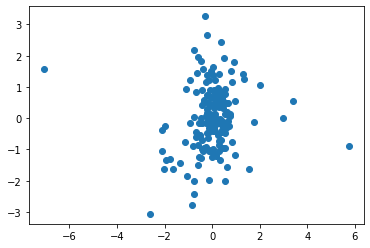

scaterplot of Government prim result against GDPpc growth dispersion:


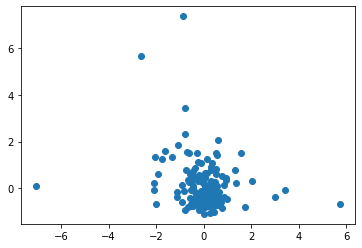

scaterplot of Government prim result against Current account balance %:


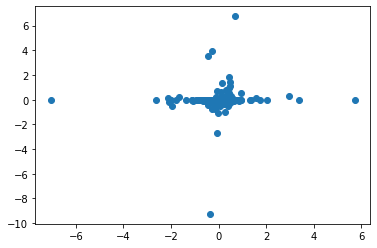

scaterplot of Government prim result against Government size %:


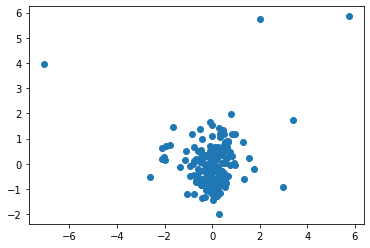

scaterplot of Government prim result against Government prim result:


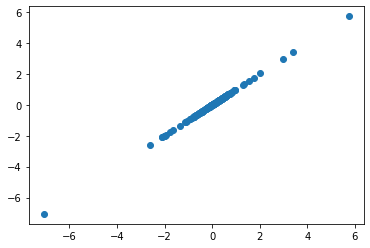

In [41]:
for columnX in scaled_kpi.columns:
    print("*"*20)
    print(f"Scatter plots with {columnX} as the base variable")
    print("*"*20)
    for columnY in scaled_kpi.columns:
        print(f"scaterplot of {columnX} against {columnY}:")
        plt.scatter(scaled_kpi[columnX],scaled_kpi[columnY])
        plt.show()

Now let's see if we can group countries together based on some combination of these variables. We'll do **kmeans**, meaning partition the dataset into K distinct, non-overlapping subsets (clusters) based on the similarity of data points. Quick overview of how KMeans works

1. **Initialization:**
   - Choose K initial cluster centroids randomly or based on some heuristic (we will do the former here).
   - Each centroid represents the initial center of a cluster.

2. **Assignment:**
   - Assign each data point to the nearest centroid, forming K clusters.
   - The proximity or similarity between data points and centroids is measured using Euclidean distance.

3. **Update Centroids:**
   - Recalculate the centroids of the K clusters based on the mean of all data points assigned to each cluster.
   - The new centroids represent the updated center of each cluster.

4. **Repeat:**
   - Repeat the assignment and update steps until convergence or a stopping criterion is met.
   - Convergence occurs when the centroids no longer change significantly between iterations.

The basic assumptions of the K-means algorithm include:
- The number of clusters (K) is known or predetermined (we will loop between 3-7 clusters to look for the optimal split).
- Clusters are spherical and equally sized.
- Each data point belongs to exactly one cluster.
- The variance within each cluster is roughly the same.

We will rely on two indicators of group "purity" to see in how many groups we should split the data, i'm thinking lets try to at least have less groups than variables

In [42]:
print("Assesing optimal split")
print("Silhouette score: average proximity within cluster vs proximity to nearest non cluster sample. close to 1=good")
print("Calinski-Harabasz score: ratio of the between-cluster variance to the within-cluster variance. high is good")
print("*"*20)

results_df = pd.DataFrame(columns=['K', 'Silhouette Score', 'Calinski-Harabasz Score'])

for k in range(3, 7):
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    weo_kpi[f'Cluster{k}'] = kmeans.fit_predict(scaled_kpi)

    # Assess the quality of the clustering using silhouette score
    silhouette_avg = silhouette_score(scaled_kpi, weo_kpi[f'Cluster{k}'])
    ch_score=calinski_harabasz_score(scaled_kpi, weo_kpi[f'Cluster{k}'])

    results_df = results_df.append({'K': k, 'Silhouette Score': silhouette_avg, 'Calinski-Harabasz Score': ch_score},
                                   ignore_index=True)
    # Analyze the cluster centers
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
    cluster_centers_df = pd.DataFrame(cluster_centers, columns=scaled_kpi.columns)
    cluster_centers_df['Cluster'] = range(k)
    #print(f"Cluster Centers for K={k}:\n{cluster_centers_df}")
    #print("*"*10)

Assesing optimal split
Silhouette score: average proximity within cluster vs proximity to nearest non cluster sample. close to 1=good
Calinski-Harabasz score: ratio of the between-cluster variance to the within-cluster variance. high is good
********************


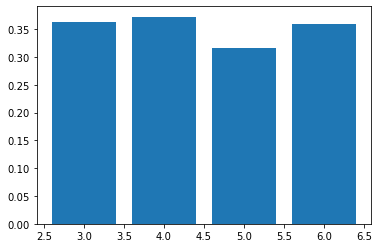

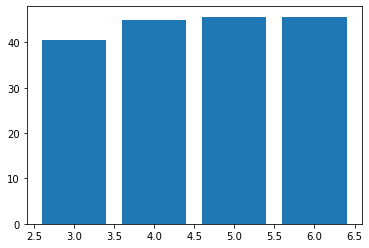

In [43]:
plt.bar(results_df.K,results_df['Silhouette Score'])
plt.show()
plt.bar(results_df.K,results_df['Calinski-Harabasz Score'])
plt.show()

looks like k=4 is a good idea

In [44]:
clustered_df=weo_kpi.groupby('Cluster4')
clustered_df['Current GDP'].count()

Cluster4
0     17
1    132
2      1
3     35
Name: Current GDP, dtype: int64

In [45]:
print(weo_kpi[weo_kpi['Cluster4']==2].index[0]) # we've got the US as a standalone category,
# which kind of makes sense but its not ideal
# when comparing "groups" cluster #2 will be the US so we might as well take it out, but ill ask the loop to do both,
# given that we haven't looked at US metrics specifically so its not like we're repeating ourselves

United States


In [46]:
kpi_noUS=weo_kpi[weo_kpi['Cluster4']!=2].copy()
clustered_df_noUS=kpi_noUS.groupby('Cluster4')

Current GDP


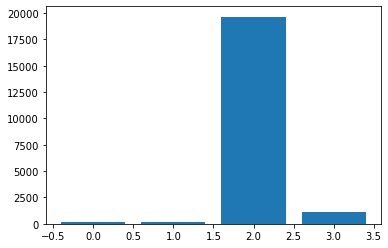

GDP per capita


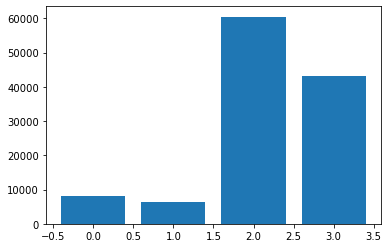

GDPpc growth


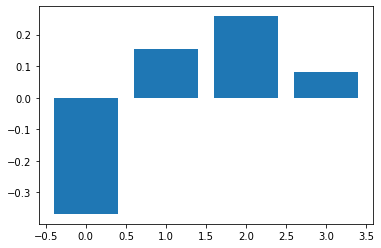

GDPpc growth dispersion


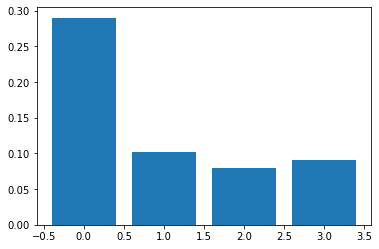

Current account balance %


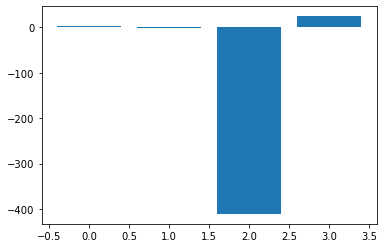

Government size %


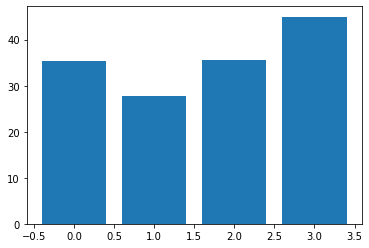

Government prim result


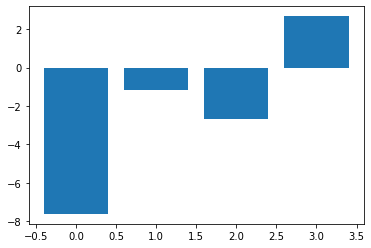

In [47]:
for sv in selected_variables.keys():
    print(f"{sv}")
    plt.bar(clustered_df[sv].mean().index,clustered_df[sv].mean())
    plt.show()

**Overview**
- Outside of the US, cluster centers dont seem to be very different in terms of gross GDP
- GDP per capita is indeed much higher for cluster 3
- Cluster 1 is made of faster growing countries (nearly 2% a year), cluster 3 averages somewhat of a sluggish growth and cluster 0 has a strong decline in gpdppc
- Disperison is similar outside of the falling gdppc countries
- Strong account balance surplus in countries in cluster 3, 0 and 1 have near zero balances
- Cluster 3 has the biggest state, roughly 30% bigger than 0 and 1
- Cluster 3 has a primary budget surplus, cluster 1 is close to equilibrium and cluster 3 has a strong deficit

Current GDP


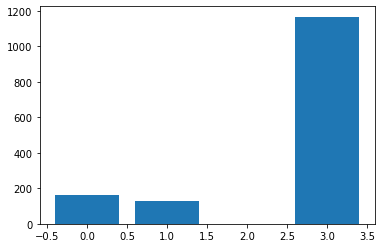

GDP per capita


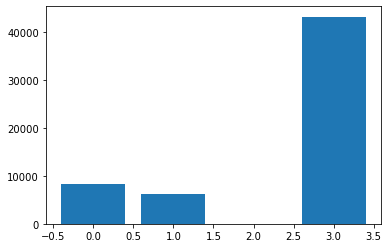

GDPpc growth


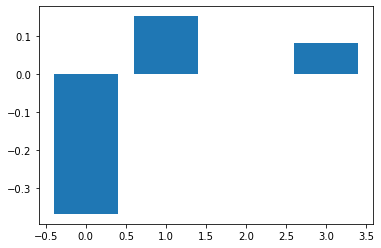

GDPpc growth dispersion


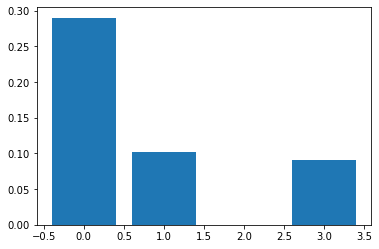

Current account balance %


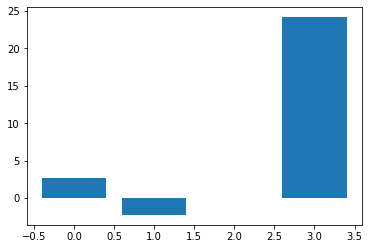

Government size %


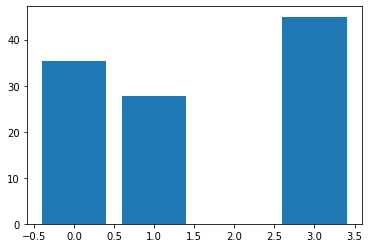

Government prim result


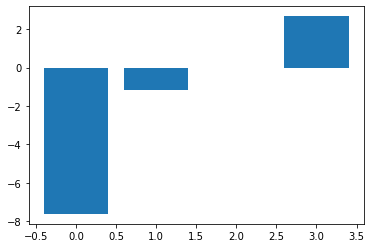

In [48]:
# taking out cluster 2 in case it weirding up one of the scales
for sv in selected_variables.keys():
    print(f"{sv}")
    plt.bar(clustered_df_noUS[sv].mean().index,clustered_df_noUS[sv].mean())
    plt.show()

So we see that the groups are different in terms of the selected variables, but it would be interesting to decompose the overall separation in terms of variable importance. it is also possible that variability is reduced to a smaller subset of variables so we could even improve on our clustering. therefore we will use PCA

**Principal Component Analysis (PCA)** is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional representation while retaining as much of the original variability as possible. The process of PCA involves the following key steps:

1. **Centering the Data:**
   - The first step is to subtract the mean of each variable from the data. This centers the data around the origin, and it is necessary for PCA to work correctly.

2. **Computing the Covariance Matrix:**
   - After centering the data, the next step is to compute the covariance matrix. The covariance matrix summarizes the relationships between different variables in the dataset.

3. **Computing Eigenvalues and Eigenvectors:**
   - The eigendecomposition of the covariance matrix yields eigenvalues and corresponding eigenvectors.
   - Eigenvalues represent the amount of variance explained by each principal component, and eigenvectors represent the direction of maximum variance in the data.
   - Principal components are linear combinations of the original variables and are derived from the eigenvectors.

4. **Selecting Principal Components:**
   - Principal components are ranked based on their corresponding eigenvalues, with the highest eigenvalue indicating the direction of maximum variance.
   - Typically, you select the top \(k\) principal components that capture a sufficiently high percentage of the total variance. This allows you to reduce the dimensionality of the data while retaining most of the information.

5. **Transforming the Data:**
   - The original data is then projected onto the selected principal components to obtain the lower-dimensional representation.
   - The transformation is done by multiplying the original data matrix by the matrix of selected eigenvectors.

PCA provides a new set of orthogonal axes (principal components) that capture the most significant directions of variance in the data. By choosing a subset of these components, you can represent the data in a lower-dimensional space while preserving most of the information.

In [49]:
X = scaled_kpi  # Use the scaled DataFrame

pca = PCA() #no dimentionality reduction
principal_components = pca.fit_transform(X)

In [50]:
pca.components_

array([[ 0.31620993,  0.50583645,  0.28914321, -0.47288929, -0.07024901,
         0.3368921 ,  0.46742002],
       [ 0.57685642,  0.24575272, -0.35181458,  0.3434036 , -0.50944492,
         0.15986855, -0.28293223],
       [ 0.27078257, -0.32050652,  0.51816949, -0.28984245, -0.45757478,
        -0.4824761 , -0.17113221],
       [-0.29202613, -0.38663796, -0.22114478,  0.04375378, -0.59318381,
         0.18894453,  0.5717039 ],
       [-0.06973533, -0.32098331,  0.38860499,  0.0069114 , -0.03835798,
         0.76382714, -0.3951479 ],
       [ 0.25877388, -0.08081919,  0.46876317,  0.71592227,  0.17782814,
        -0.03873413,  0.40136959],
       [ 0.58036071, -0.56741494, -0.32321095, -0.24481459,  0.3757593 ,
         0.08677732,  0.16762123]])

The shape of pca.components_ is (n_components, n_features), where n_components is the number of principal components you chose to retain, and n_features is the number of original features in your dataset.

- Each row in pca.components_ corresponds to one principal component.
- The elements within each row represent the weights or loadings of the original features on that principal component.
- The larger the absolute value of a weight, the more influential the corresponding feature is on that principal component.

In [51]:
# Get loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i}' for i in range(1, len(X.columns) + 1)], index=X.columns)

In [52]:
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Current GDP,0.316210,0.576856,0.270783,-0.292026,-0.069735,0.258774,0.580361
GDP per capita,0.505836,0.245753,-0.320507,-0.386638,-0.320983,-0.080819,-0.567415
GDPpc growth,0.289143,-0.351815,0.518169,-0.221145,0.388605,0.468763,-0.323211
GDPpc growth dispersion,-0.472889,0.343404,-0.289842,0.043754,0.006911,0.715922,-0.244815
Current account balance %,-0.070249,-0.509445,-0.457575,-0.593184,-0.038358,0.177828,0.375759
Government size %,0.336892,0.159869,-0.482476,0.188945,0.763827,-0.038734,0.086777
Government prim result,0.467420,-0.282932,-0.171132,0.571704,-0.395148,0.401370,0.167621


- The loadings indicate the correlation between each original variable and each principal component.
- Variables with higher absolute loading values (positive or negative) contribute more to the corresponding principal component.

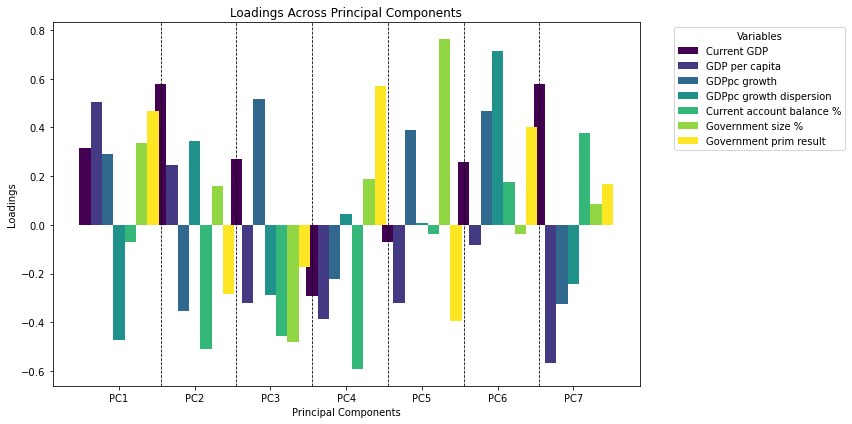

In [53]:
# Set up the color map
colors = plt.cm.viridis(np.linspace(0, 1, len(loadings.index)))

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.15  # Adjust this value based on your preference

for i, (var, color) in enumerate(zip(loadings.index, colors)):
    x_values = np.arange(len(loadings.columns)) + i * bar_width
    ax.bar(x_values, loadings.loc[var], width=bar_width, label=var, color=color)

# Add vertical lines to separate groups of bars
for i in range(len(loadings.columns) - 1):
    ax.axvline(i+1, color='black', linestyle='--', linewidth=0.8)

ax.set_xticks(np.arange(len(loadings.columns)) + (len(loadings.index) - 1) * bar_width / 2)
ax.set_xticklabels(loadings.columns)
ax.set_xlabel('Principal Components')
ax.set_ylabel('Loadings')
ax.legend(title='Variables', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Loadings Across Principal Components')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

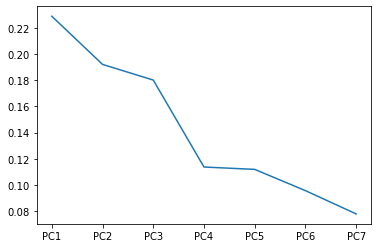

In [54]:
explained_variance = pca.explained_variance_ratio_
plt.plot([f'PC{i}' for i in range(1, len(X.columns) + 1)],explained_variance)

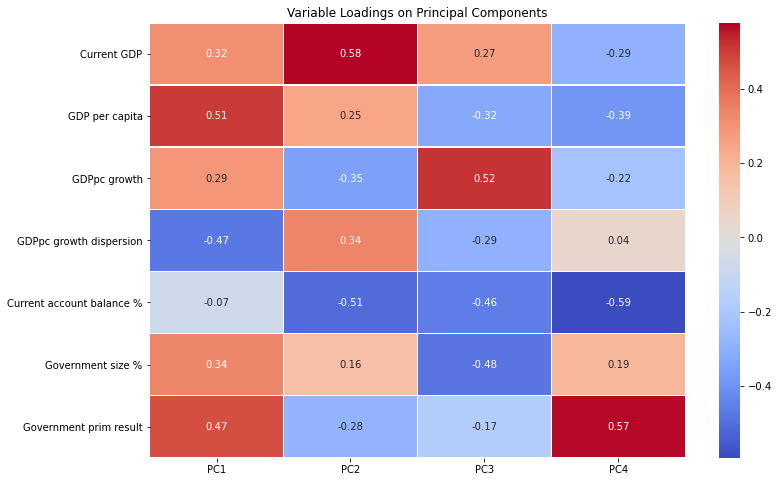

In [56]:
# Heatmap of loadings
plt.figure(figsize=(12, 8))
sns.heatmap(loadings.iloc[:,:4], cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Variable Loadings on Principal Components')
plt.show()

Looking at the first 4 components (taking up 70% of explained variance):

PC1: The first principal component is the direction over which data is most stretched. 25% of all variability is explained by this "direction", which is  a linear combination of the original features; its value for each observation is influenced by the values of the original features weighted by their loadings.

- GDP per capita, primary fiscal result, and government size positively contribute the most.
- Growth dispersion negatively contributes the most.
- The other features have smaller contributions.

PC2: 
- Current GDP (+) the most important variable, the growth dispersion
- Current account balance, then GDP growth (-)

PC3:
- GDP growth (+) current account and govt size (-) but overall more mixed effects

PC4:
- Primary result (+) CA balance (-)

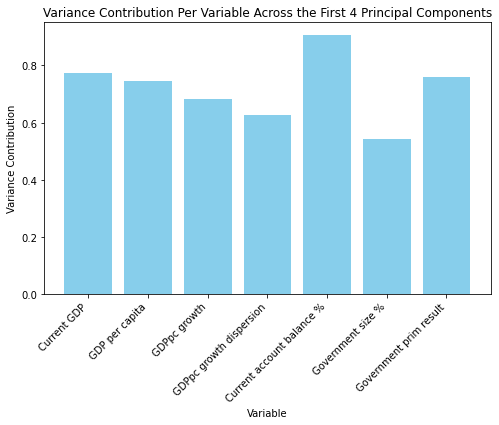

In [60]:
# Assuming you've standardized your data
pca = PCA(n_components=4)
principal_components = pca.fit_transform(X)

# Loadings matrix
loadings_matrix = pca.components_.T

# Variance contribution per variable across the first 4 principal components
variance_contribution_per_variable = np.sum((loadings_matrix ** 2) * pca.explained_variance_, axis=1)

# Plotting variance contribution per variable
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(X.columns, variance_contribution_per_variable, color='skyblue')
ax.set_xlabel('Variable')
ax.set_ylabel('Variance Contribution')
ax.set_title('Variance Contribution Per Variable Across the First 4 Principal Components')
plt.xticks(rotation=45, ha='right')


plt.show()

The contribution to the variance is pretty uniform across variables
lets go back to our clusters

Small, sluggish growth countries with deficitiary governments:

In [69]:
print(weo_kpi[weo_kpi['Cluster4']==0].index.tolist())

['Algeria', 'Angola', 'Azerbaijan', 'Brunei Darussalam', 'Republic of Congo', 'Equatorial Guinea', 'Islamic Republic of Iran', 'Kuwait', 'Libya', 'Oman', 'Russia', 'South Sudan', 'Sudan', 'Suriname', 'Timor-Leste', 'Venezuela', 'Yemen']


Small, growing countries (generally fiscally balanced):

In [70]:
print(weo_kpi[weo_kpi['Cluster4']==1].index.tolist())

['Afghanistan', 'Albania', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'The Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Democratic Republic of the Congo', 'Costa Rica', "C�te d'Ivoire", 'Croatia', 'Czech Republic', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Gabon', 'The Gambia', 'Georgia', 'Ghana', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'India', 'Indonesia', 'Iraq', 'Jamaica', 'Jordan', 'Kazakhstan', 'Kenya', 'Kosovo', 'Kyrgyz Republic', 'Lao P.D.R.', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Marshall Islands', 'Maur

Big/rich countries

In [71]:
print(weo_kpi[weo_kpi['Cluster4']==3].index.tolist())

['Australia', 'Austria', 'Belgium', 'Canada', 'China', 'Cyprus', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Hong Kong SAR', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kiribati', 'Korea', 'Luxembourg', 'Macao SAR', 'Malta', 'Micronesia', 'Netherlands', 'New Zealand', 'Norway', 'Portugal', 'Qatar', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Tuvalu', 'United Arab Emirates', 'United Kingdom']


plus the US